# OPEN SYSTEM BEHAVIOUR

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

Maximum biomass: 52.37 g/L at 32.10 hours


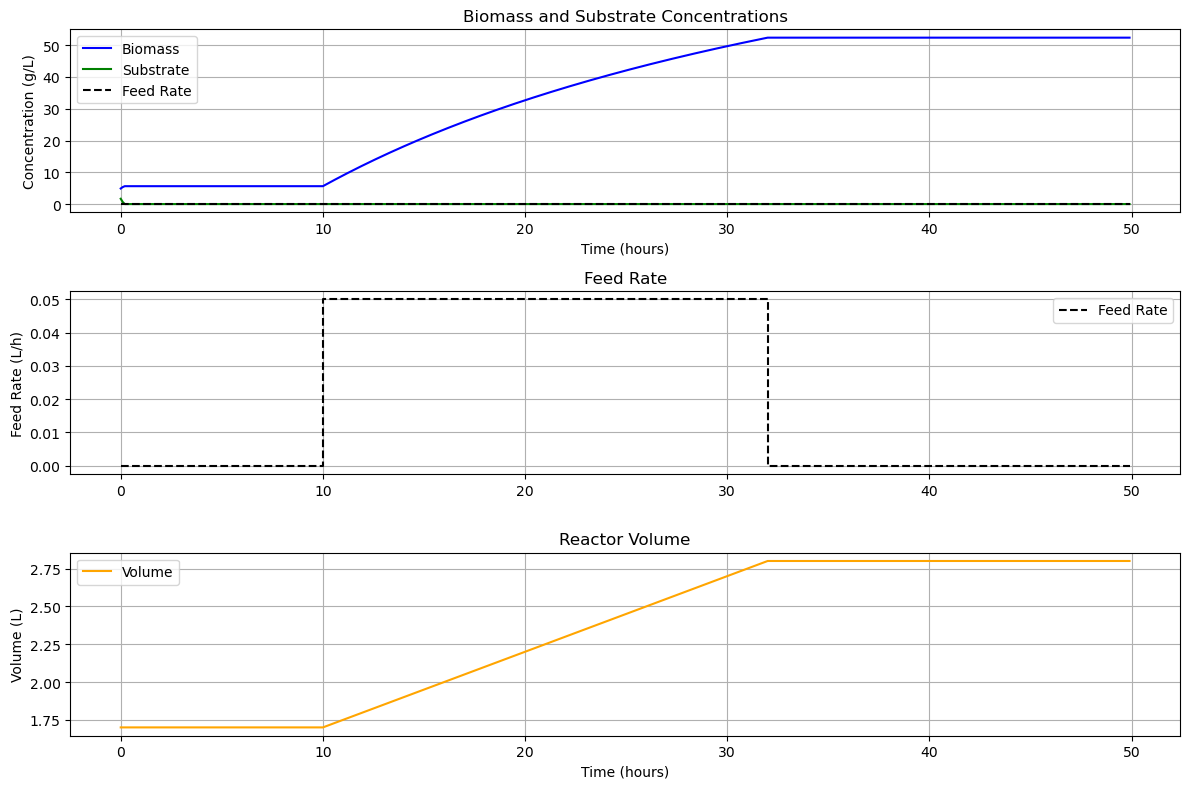

In [92]:
# Number of data points
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.86980       # 1/h
K_S    = 0.000123762   # g/l
Y_XS   = 0.4357        # g/g
S_F    = 286           # g/l

# Initial conditions
X_0 = 4.9
S_0 = 1.673
V_0 = 1.7
Vmax = 2.8           # Maximum reactor volume

# Time parameters
T_START = 0
T_END = 50
dt = 0.1

def Fs(t, V):
    if V >= Vmax:
        return 0.0      # Stop feeding when volume reaches Vmax
    elif t <= 10:
        return 0
    else:
        return 0.05
    
def plant_model(t, y, F_func: callable):
    X, S, V = y
    F = F_func(t)      # F is now dynamically calculated using Fs(t, V)
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

def simulate(F: callable, plot: bool=True) -> np.ndarray:
    """ Simulate bioreactor system using ODEs """
    t_points = np.arange(T_START, T_END, dt)
    
    # Use lambda to pass current V to F(t, V)
    sol = solve_ivp(
        lambda t, y: plant_model(t, y, lambda t: F(t, y[2])),  # y[2] = current volume V
        t_span=(T_START, T_END),
        y0=[X_0, S_0, V_0],
        t_eval=t_points,
        method='LSODA',
        rtol=1e-6,
        atol=1e-12
    )
    
    # Compute actual F(t, V) used during simulation
    F_actual = [F(t, V) for t, V in zip(sol.t, sol.y[2])]

    print(f'Maximum biomass: {np.max(sol.y[0]):.2f} g/L at {sol.t[np.argmax(sol.y[0])]:.2f} hours')

    
    
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot Biomass and Substrate
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(sol.t, sol.y[0], label='Biomass', color='blue')
        ax1.plot(sol.t, sol.y[1], label='Substrate', color='green')
        ax1.step(sol.t, F_actual, label='Feed Rate', color='black', linestyle='--')
        ax1.set_title('Biomass and Substrate Concentrations')
        ax1.set_xlabel('Time (hours)')
        ax1.set_ylabel('Concentration (g/L)')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot Feed Rate 
        ax2 = plt.subplot(3, 1, 2)
        ax2.step(sol.t, F_actual, label='Feed Rate', color='black', linestyle='--')
        ax2.set_ylabel('Feed Rate (L/h)')
        ax2.set_title('Feed Rate')
        ax2.legend(loc='upper right')
        ax2.grid()

        # Plot Volume
        ax3 = plt.subplot(3, 1, 3)
        ax3.plot(sol.t, sol.y[2], label='Volume', color='orange')
        ax3.set_title('Reactor Volume')
        ax3.set_xlabel('Time (hours)')
        ax3.set_ylabel('Volume (L)')
        ax3.legend()
        ax3.grid()

        plt.tight_layout()
        plt.show()
    return sol

sol = simulate(Fs)

In [89]:
max(sol.y[2])

2.5450000000000097